# Predicting ETF Volatility and Volume with Tick Data

So far, we have scraped minute ticker data going back to 2013. This resulted in a data set with over 1,000,000 rows and 80 columns. We will build a neural network model that detects whether any of our 16 chosen ETFs will have high volume or volatility that day. To simualte real-life trading, we will want to be screening ETFs in the morning in order to figure out which ones would be good for trading that day. Thus, to train our model, we will only use ticker data from 8:00am until 10:00am EST.

In [1]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import datetime
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, Embedding, Conv2D
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.optimizers import SGD
from keras import backend as K
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
np.random.seed(0)

api = tradeapi.REST(
    base_url=os.environ['APCA_API_BASE_URL'],
    key_id=os.environ['APCA_API_KEY_ID'],
    secret_key=os.environ['APCA_API_SECRET_KEY']
)

Using TensorFlow backend.


In [2]:
# Pick ETF Universe
symbols = [
    'XLF', # Financials
    'GDX', # Gold miners
    'VXX', # Volatility (Options)
    'EEM', # Emerging Markets
    'XRT', # S&P Retail
    'VTI', # Vanguard Total Stock Market
    'EWJ', # Japanese Market 
    'FXI', # China Large Cap
    'XHB', # S&P Homebuilders (Tracks real estate)
    'TLT', # 20 yr Treasury Bond
    'USO', # US Oil Fund
    'DBC', # Commodity Tracking
    'GLD', # Gold
    'SPY', # S&P 500
    'QQQ', # Nasdaq 100
    'XSW', # Computer Software
]

In [3]:
ticker_data = pd.read_csv('data/ticker_data.csv', index_col=0)
ticker_data.index = pd.to_datetime(ticker_data.index, utc=True).tz_convert('US/Eastern') 
ticker_data.sort_index(inplace=True)
ticker_data.head()

,close_DBC,close_EEM,close_EWJ,close_FXI,close_GDX,close_GLD,close_QQQ,close_SPY,close_TLT,close_USO,...,volume_QQQ,volume_SPY,volume_TLT,volume_USO,volume_VTI,volume_VXX,volume_XHB,volume_XLF,volume_XRT,volume_XSW
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-12-02 09:30:00-05:00,25.45,42.22,48.22,40.210,21.83,119.2400,85.85,181.17,103.7501,33.4601,...,271251.0,611002.0,18273.0,8565.0,2113.0,2967.0,2210.0,104372.0,24362.0,360.0
2013-12-02 09:31:00-05:00,25.44,42.23,48.20,40.250,21.81,119.2500,85.80,181.11,103.7500,33.4700,...,130647.0,421107.0,25366.0,31738.0,4969.0,3267.0,705.0,15900.0,58946.0,360.0
2013-12-02 09:32:00-05:00,25.44,42.23,48.20,40.240,21.78,119.2003,85.81,181.09,103.7600,33.4500,...,185792.0,323517.0,21107.0,38347.0,3353.0,6017.0,1000.0,753186.0,90852.0,360.0
2013-12-02 09:33:00-05:00,25.44,42.25,48.20,40.270,21.78,119.1600,85.85,181.12,103.7300,33.4545,...,108899.0,334016.0,17038.0,1500.0,3905.0,4631.0,2518.0,46024.0,18040.0,360.0
2013-12-02 09:34:00-05:00,25.44,42.25,48.20,40.285,21.79,119.1900,85.85,181.11,103.7000,33.4600,...,92022.0,223915.0,31593.0,5900.0,3251.0,2886.0,1100.0,47806.0,3950.0,360.0


In [5]:
returns = ticker_data[[c for c in ticker_data.columns if 'close_' in c]].resample('D').first().pct_change()

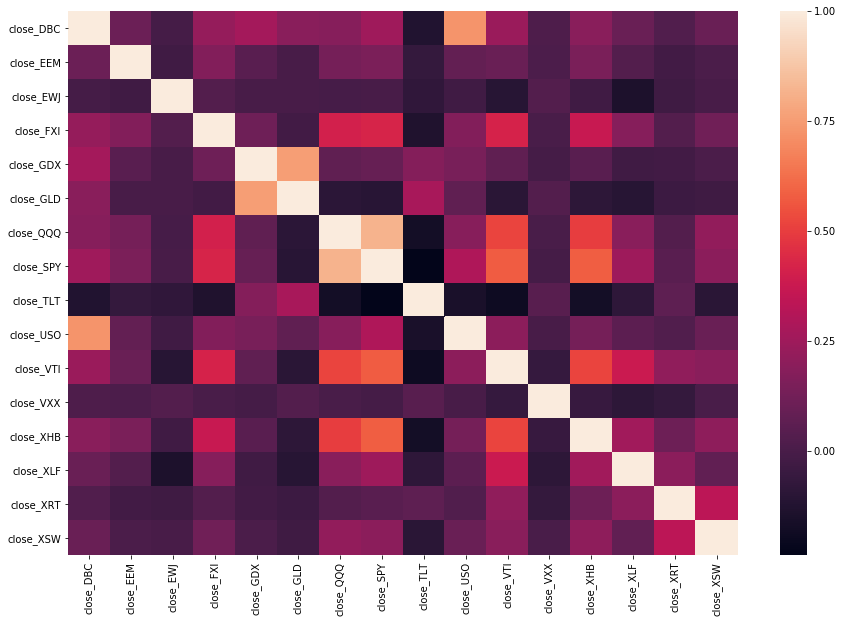

In [10]:
plt.figure(figsize=(15, 10))
sns.heatmap(returns.dropna().corr())
plt.show()

In [6]:
ticker_data.tail()

,close_DBC,close_EEM,close_EWJ,close_FXI,close_GDX,close_GLD,close_QQQ,close_SPY,close_TLT,close_USO,...,volume_QQQ,volume_SPY,volume_TLT,volume_USO,volume_VTI,volume_VXX,volume_XHB,volume_XLF,volume_XRT,volume_XSW
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-13 18:42:00-04:00,15.215,41.56,54.1543,40.81,23.3,126.8,182.98,289.54,131.15,10.87,...,2460.0,3103.0,500.0,1000.0,565.0,322.0,5553.0,1001.0,500.0,744.0
2019-06-13 18:43:00-04:00,15.215,41.56,54.1543,40.81,23.3,126.8,182.97,289.54,131.15,10.87,...,400.0,3103.0,500.0,1000.0,565.0,322.0,5553.0,1001.0,500.0,744.0
2019-06-13 18:44:00-04:00,15.215,41.56,54.1543,40.81,23.3,126.8,183.02,289.54,131.15,10.87,...,5000.0,3103.0,500.0,1000.0,565.0,322.0,5553.0,1001.0,500.0,744.0
2019-06-13 18:45:00-04:00,15.215,41.56,54.1543,40.81,23.3,126.8,182.99,289.54,131.15,10.87,...,2000.0,3103.0,500.0,1000.0,565.0,322.0,5553.0,1001.0,500.0,744.0
2019-06-13 18:46:00-04:00,15.215,41.56,54.1543,40.81,23.3,126.8,183.00,289.54,131.15,10.87,...,5000.0,3103.0,500.0,1000.0,565.0,322.0,5553.0,1001.0,500.0,744.0


Our data goes back until 2013-12-02 09:30:00-05:00, but we will lookback a day ahead of this so that we can capture trading before the market opens as well. The New York Stock Exchange opens are precisely 9:30am and closes at 4:00pm EST M-F except on national holidays. Before hours trading is trading that occurs slightly before market open and slightly after market close. Sometimes, if news strikes during this time or if a certain company reports earnings, before hours trading can yield a good signal as to how the market will react during regular market hours.

We want to detect high market volatility and / or volume. A good stand-in for volatility is seeing how far the High and Low points during the day differ from each other. If this value is particularly high, we can assume the ETF had high volatility for that day. Our data source supplies daily volume as well. Thus, our y training data represents whether or not any of the 16 ETFs traded within the top quantile of estimated volatility or volume that day.

Our X data will represent the OHLCV bars for each ETF from 8:00am until 10:00am daily. Note that for ML purposes, we will need to reshape each of these daily windows to represent a 1D vector per day. Thus, we will reshape each OHLCV bar for each ETF during these hours into a single vector. This will act as a single training data point.

In [2]:
lookback = pd.to_datetime('2013-12-03 00:00:00')
lookforward = pd.to_datetime('2019-06-06 00:00:00')

In [6]:
def get_volatility(data, symbols=symbols):
    """ Gets daily average volatility during tradable hours. """
    out = {}
    for symbol in symbols:
        out[symbol] = data['close_' + symbol].between_time('09:30', '15:59').groupby(pd.Grouper(freq='D')).std().dropna()
    return pd.concat(out, axis=1) 


def get_volume(data, symbols=symbols):
    """ Gets daily total volume during tradable hours. """
    out = {}
    for symbol in symbols:
        out[symbol] = data['volume_' + symbol].between_time('09:30', '15:59').groupby(pd.Grouper(freq='D')).sum().dropna()
        
    return pd.concat(out, axis=1) 

def get_data(ticker_data=ticker_data, symbols=symbols, lookback=lookback, lookforward=lookforward):
    """ Gets data denoted as in-play, i.e. high volume and volatility, and wraps morning tick data (8am until 10am) 
        for each of our 16 etfs as a single vector. 16 assets, 5 bars each, 121 minutes = 9680 total values per day."""
    # Get volume and volatility
    volatility = get_volatility(ticker_data)
    volume = get_volume(ticker_data)
    in_play_df = ((volatility > volatility.quantile(0.5)) & (volume > volume.quantile(0.5))).dropna() 
    in_play_df = in_play_df.astype('int64')

    btw_days = (lookforward - lookback).days
    
    # Store each range
    chunks = []
    idx = []
    for day in range(1, btw_days + 1):
        curr_date = str((lookback + datetime.timedelta(days=day)).date())
        # Lookback over past 120 minutes
        try:
            chunks.append(ticker_data.loc[curr_date].between_time('08:00:00', '10:00:00').values.reshape(121*80,))
            idx.append(pd.to_datetime(curr_date).tz_localize('US/Eastern'))
        except:
            #print(curr_date)
            continue
    chunks = np.stack(chunks)
    data_chunks = pd.DataFrame(chunks, index=idx).join(in_play_df, how='left')
    
    return data_chunks[[c for c in data_chunks.columns if c not in symbols]], data_chunks[symbols].fillna(0).astype('int64')
    #return chunks, in_play_df

Using the above function, we gather our X and y data. Due to the large size of this dataset, this will take a while to execute.

In [7]:
X, y = get_data()

Let's now observe our data.

In [8]:
X.tail()

,0,1,2,3,4,5,6,7,8,9,...,9670,9671,9672,9673,9674,9675,9676,9677,9678,9679
2019-06-07 00:00:00-04:00,15.11,40.90,53.74,40.18,22.8899,126.03,178.24,285.56,130.7300,11.0700,...,122193.0,214684.0,10705.0,126177.0,4744.0,85494.0,2081.0,30094.0,6074.0,792.0
2019-06-10 00:00:00-04:00,15.17,41.54,54.40,40.90,22.4200,125.09,182.09,289.16,130.5300,11.3000,...,77681.0,116585.0,9173.0,267437.0,4403.0,157726.0,4216.0,558118.0,39289.0,471.0
2019-06-11 00:00:00-04:00,15.13,42.00,54.89,41.43,22.2800,124.57,184.55,290.50,129.8999,11.1901,...,87006.0,121985.0,1416.0,65285.0,19227.0,73648.0,2806.0,97205.0,120091.0,182.0
2019-06-12 00:00:00-04:00,15.30,41.72,54.80,40.80,22.8500,125.98,182.54,288.13,131.1000,10.8099,...,76477.0,60575.0,8241.0,25336.0,27384.0,43067.0,1170.0,81320.0,5440.0,396.0
2019-06-13 00:00:00-04:00,15.03,41.72,54.21,41.00,23.0300,126.20,183.12,289.29,130.7700,11.0400,...,153804.0,100971.0,6586.0,191864.0,16944.0,77835.0,700.0,146127.0,19312.0,170.0


In [9]:
X.shape

(5, 9680)

In [12]:
y.head()

,XLF,GDX,VXX,EEM,XRT,VTI,EWJ,FXI,XHB,TLT,USO,DBC,GLD,SPY,QQQ,XSW
2013-12-04 00:00:00-05:00,1,1,0,1,0,1,1,1,1,0,0,0,1,1,0,0
2013-12-05 00:00:00-05:00,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2013-12-06 00:00:00-05:00,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
2013-12-09 00:00:00-05:00,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
2013-12-10 00:00:00-05:00,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [13]:
y.shape

(1268, 16)

To validate our model, we want to consider most recent data as this will simulate model performance in a real-time trading scenario. In our case, we will look at the last 10 trading days.

In [14]:
# Evaluate on last week
days = 10
X_train, X_val = X.iloc[:-days, :], X.iloc[-days:, :]
y_train, y_val = y.iloc[:-days, :], y.iloc[-days:, :]

Our model consists of time-series data, so we want to capture this time relationship with a recurrent layer. An LSTM will capture how the data behaves over time. To make our data usable for an LSTM, we will reshape it into a 3D tensor such that each height represents the number of trading days, length represents the number of minutes seen during that day, and width represents each OHLCV value per asset for a total of 80 different values. The LSTM will capture how each of these 80 values behave over the 120 minutes of early morning trading. Note that will fit a MinMaxScaler to our training data and transform both the training and validation data in their original format. This will attempt to eliminate exploding gradients.

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], 121, 80)
X_val = scaler.transform(X_val).reshape(X_val.shape[0], 121, 80)

Recall that on any given day, more than one of our ETFs can have higher than normal volatility or volume. Thus, our machine learning problem is phrased as a multilabel one rather than a multiclass one. We want to be able to predict more than one ETF as 'in-play' if necessary. If we use a binary_crossentropy loss function and a sigmoid activation function, Keras will treat each class as it's own binary classification output variable, allowing us to predict more than one label at a time.

In [16]:
input_ = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = CuDNNLSTM(40, return_sequences=True)(input_)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = Dense(y_train.shape[1], activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)
# Choose Multilabel
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.fit(X_train, y_train.values, epochs=30, validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1258 samples, validate on 10 samples
Epoch 1/30
1258/1258 [==============================] - 13s 10ms/step - loss: 0.6750 - acc: 0.5734 - val_loss: 0.6660 - val_acc: 0.5000
Epoch 2/30
1258/1258 [==============================] - 1s 600us/step - loss: 0.6489 - acc: 0.6152 - val_loss: 0.6479 - val_acc: 0.6125
Epoch 3/30
1258/1258 [==============================] - 1s 569us/step - loss: 0.6258 - acc: 0.6521 - val_loss: 0.6753 - val_acc: 0.6062
Epoch 4/30
1258/1258 [==============================] - 1s 536us/step - loss: 0.6043 - acc: 0.6726 - val_loss: 0.6468 - val_acc: 0.6125
Epoch 5/30
1258/1258 [==============================] - 1s 537us/step - loss: 0.5857 - acc: 0.6859 - val_loss: 0.6000 - val_acc: 0.6375
Epoch 6/30
1258/1258 [==============================] - 1s 538us/step - loss: 0.5760 - acc: 0.6945 - val_loss: 0.7363 - val_acc: 0.5188
Epoch 7/30
1

In [18]:
y_pred = model.predict(X_val)

In [26]:
# Get test accuracy
y_pred = pd.DataFrame(y_pred, index=y_val.index, columns=y_val.columns) 
((y_pred > 0.5).astype('int64') == y_val).sum().sum() / (y_pred.shape[0] * y_pred.shape[1])

0.6375

In [21]:
# Save data to avoid resampling
X.to_csv('data/wrapped_tick_data.csv')